Baseline models are important for 2 key reaons:
1. Baseline models give us a starting point to which to compare all future models, and
2. Smart baselines/averages may be needed to fill in missing data for more complicated models

Here, we'll explore a few typical baseline models for recommender systems and see which ones do the best for our dataset.

In [1]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
from sklearn.metrics import mean_absolute_error
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('../big-darkgrid.mplstyle')

# 1. Load the Data

Let's load and examine the ratings data.
From here on until the very end of this project, we want to keep a holdout set that we won't touch except to evaluate a few models we choose based on cross-validation and other metrics.
Here we'll split the data into reviews through 2013 for training and years 2014 and on as our holdout set.
We do this instead of splitting randomly so that we don't get data leakage from the future during model development.
We'll save these files as feather files for fast future loading.

In [2]:
# <!-- collapse=True -->
# This was created in 01_Initial_Ratings_EDA.ipynb
ratings_feather = '../preprocessed/ratings.feather'
# These were/will be created here
ratings_through_2013_feather = '../preprocessed/ratings-through-2013.feather'
ratings_2014_through_2015_feather = '../preprocessed/ratings-2014-through-2015.feather'

if exists(ratings_through_2013_feather) and exists(ratings_2014_through_2015_feather):
    print("Loading {}".format(ratings_through_2013_feather))
    ratings_df = pd.read_feather(ratings_through_2013_feather)
else:
    ratings_df_full = pd.read_feather(ratings_feather)
    ratings_df = ratings_df_full[ratings_df_full['year'] <= 2013].copy()
    print("Writing {}".format(ratings_through_2013_feather))
    ratings_df.to_feather(ratings_through_2013_feather)
    print("Writing {}".format(ratings_2014_through_2015_feather))
    (ratings_df_full[ratings_df_full['year']>=2014]
     .reset_index(drop=True)
     .to_feather(ratings_2014_through_2015_feather)
    )
    del ratings_df_full
    gc.collect()
display(ratings_df.tail())

Loading ../preprocessed/ratings-through-2013.feather


,userId,movieId,rating,timestamp,year,month,day,hour,minute
19153905,120609,81562,3.0,2013-12-31 23:57:27,2013,12,31,23,57
19153906,120609,356,2.5,2013-12-31 23:57:36,2013,12,31,23,57
19153907,120609,74458,4.0,2013-12-31 23:57:47,2013,12,31,23,57
19153908,44501,70533,4.5,2013-12-31 23:58:07,2013,12,31,23,58
19153909,44501,96821,4.0,2013-12-31 23:58:34,2013,12,31,23,58


# 2. Establish Cross-Validation Technique

Before getting into model development, it's important to establish the performance of some baseline models to compare to. Simple cross-validation doesn't take into account the time-dependence of the reviews. Instead, we will validate the baseline models using a kind of rolling cross-validation that only predicts future data from past data. This process can be visualized as follows (image linked from [StackOverflow](https://stats.stackexchange.com/a/268847/134464)):

![Rolling Cross-Validation Schematic](https://i.stack.imgur.com/fXZ6k.png)

In this case, we'll use 2-year intervals for each test set. Scikit-learn has a class called [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) which is close to how we want to split the data for each test, but it only allows splitting by number of rows, not by a fixed time period. We'll make our own class to implement this with a similar interface.

In [3]:
# <!-- collapse=True -->
class TimeSeriesSplitByYear():
    """Cross-validation splitter for data with a time-component that splits
    by intervals of 'n_years' years.
    
    Parameters
    ----------
    n_years : int, default=2
        Number of years in each test set. For example, with n_years=2, for
        fold 1, the first 2 years will be used as training data and the next
        2 years will be used for testing. For fold 2, the first 4 years will
        be used as training data and the next 2 years will be used for
        testing, etc.
    """
    def __init__(self, n_years=2):
        self.n_years_ = n_years
        
    def split(self, X, years_data=None):
        """Generator that iteratively returns training and testing indices for each fold.
        
        Parameters
        ----------
        X : pd.DataFrame or array-like, shape=(n_records, n_fields)
            n_records for X must equal n_records for years_data if given, but otherwise
            will not be used unless it's a dataframe with a 'year' column.
        years_data : array-like, shape=(n_records,), optional
            If X is not a dataframe with a 'year' column, years_data is necessary.
            
        Returns
        -------
        train_inds : boolean np.array, shape=(n_records,)
            True for indices in the training set, otherwise False
        test_inds : boolean np.array, shape=(n_records,)
            True for indices in the test set, otherwise False
        """
        if years_data is None:
            try:
                years_data = X['year']
            except:
                raise ValueError("If years_data not provided, X must be a dataframe with 'year' column")
            if 'year' in X.columns:
                years_data = X['year']
        if len(years_data) != len(X):
            raise ValueError("length of years_data must match length of X!")
        years = np.array(years_data)
        unique_years = np.unique(years)
        for year in unique_years[self.n_years_::self.n_years_]:
            train_inds = years < year
            test_inds = (years >= year) & (years < year + self.n_years_)
            yield train_inds, test_inds

Now that we have our cross-validation splitting framework set up, let's set up a framework to run our custom validation. For each time period that we test, we'll compute the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), which is a commonly used error metric for recommender systems. We'll set up the `validate()` member function for this class to return the list of years and errors to facilitate plotting the error over time.

In [4]:
# <!-- collapse=True -->
class PerformanceOverTimeValidator():
    """Validator that evaluates model performance over time. For each time
    period tested, all data before that time period is used as training data.
    
    Parameters
    ----------
    model : object
        An object with public fit(X, y) and predict(X) methods.
    err_func : function, default=sklearn.metrics.mean_absolute_error
        A function used to evaluate performance for each time period.
        Arguments are y and y_pred, both of which are array-like with
        shape = [n_samples]
    n_year_period : int, default=1
        Number of years per test period
        
    Attributes
    ----------
    model_ : object
        Model passed in parameters
    err_func_ : function
        Error function passed in parameters
    n_year_period_ : int
        n_year_period passed in parameters
    test_years_ : int list
        List of years, each of which marks the first year
        in a tested time period
    test_errs_ : float list, [n_periods_tested]
        List of test errors for each time period tested
    
    """
    def __init__(self, model, err_func=mean_absolute_error, n_year_period=1):
        self.model_ = model
        self.err_func_ = err_func
        self.n_year_period_ = n_year_period
        self.test_years_ = []
        self.test_errs_ = []
        
    def validate(self, X, y, years):
        """Computes test error using all previous data as training data
        over a set of years
        
        Paramters
        ---------
        X : {array-like}, shape = [n_samples, n_features]
            Feature vectors
        y : array-like, shape = [n_samples]
            Target variables
        years : array-like, shape = [n_samples]
        
        Returns
        -------
        test_years_ : int list, [n_periods_tested]
            List of years, each of which marks the first year
            in a tested time period
        test_errs_ : float list, [n_periods_tested]
            List of test errors for each time period tested
        """
        years = np.array(years)
        unique_years = np.unique(years)
        test_years = []
        test_errs = []
        # for year in unique_years[self.n_year_period_::self.n_year_period_]:
        #     train_inds = years < year
        #     test_inds = (years >= year) & (years < year + self.n_year_period_)
        splitter = TimeSeriesSplitByYear(n_years=2)
        for train_inds, test_inds in splitter.split(X, years_data=years):
            X_train, y_train = X[train_inds], y[train_inds]
            X_test, y_test = X[test_inds], y[test_inds]
            self.model_.fit(X_train, y_train)
            y_pred = self.model_.predict(X_test)
            err = self.err_func_(y_pred, y_test)
            year = years[test_inds][0]
            test_years.append(year)
            test_errs.append(err)
        self.test_years_ = test_years
        self.test_errs_ = test_errs
        return test_years, test_errs

# 3. Testing Baseline Models

With all that framework setup out of the way, let's evaluate a few baseline models in increasing order of expected accuracy.

## 3.1 Simple Average Model

The first model we'll test is about the simplest one possible. We'll just average all the training set ratings and use that average for the prediction for all test set examples.

In [5]:
# <!-- collapse=True -->
class SimpleAverageModel():
    """The simplest possible model that just uses the average of the ratings in the
    training set as the prediction for the test set.
    
    Attributes
    ----------
    mean_ : float
        Average of the training set ratings
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.mean_ = y.mean()
    
    def predict(self, X):
        return np.ones(len(X)) * self.mean_

## 3.2 Average by ID Model

We can probably do a little better by using the user or item (movie) average. Here we'll set up a baseline model class that allows you to pass either a list of `userId`s or `movieId`s as `X`. The prediction for a given ID will just be the average of ratings from that ID, or the overall average if that ID wasn't seen in the training set.

In [6]:
# <!-- collapse=True -->
class AverageByIdModel():
    """Simple model that predicts based on average ratings for a given Id
    (movieId or userId) from training data
    
    Attributes
    ----------
    averages_by_id_ : pandas Series, shape = [n_ids]
        Pandas series of rating averages by id
    overall_average_ : float
        Average rating over all training samples
    """

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_samples]
            Array of n_samples movieIds or userIds
        y : array-like, shape = [n_samples]
            Target values (movie ratings)
        
        Returns
        -------
        self : object
        """
        X_y_df = pd.DataFrame({'id': X, 'rating': y})
        self.averages_by_id_ = (
            X_y_df
            .groupby('id')['rating']
            .mean()
            .rename('average_rating')
        )
        self.overall_average_ = np.mean(y)
    
    def predict(self, X):
        """Return rating predictions
        
        Parameters
        ----------
        X : array-like, shape = [n_samples]
            Array of n_samples movieIds or userIds
        
        Returns
        -------
        y_pred : array-like, shape = [n_samples]
            Array of n_samples rating predictions
        """
        if isinstance(X, pd.DataFrame):
            if X.shape[1] > 1:
                raise ValueError(
                    "X should be a 1D array-like object"
                )
            X = X.iloc[:, 0]
        X_df = pd.DataFrame({'id': X})
        X_df = X_df.join(self.averages_by_id_, on='id')
        X_df['average_rating'].fillna(self.overall_average_, inplace=True)
        return X_df['average_rating'].values

## 3.3 Damped Baseline with User + Movie Data

This baseline model takes into account the average ratings of both the user and the movie, as well as a damping factor that brings the baseline prediction closer to the overall mean. The damping factor has been shown empirically to improve the perfomance.

This model follows equation 2.1 from a [collaborative filtering paper]((http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf) from [GroupLens](https://grouplens.org/), the same group that published the MovieLens data. This equation defines rhe baseline rating for user $u$ and item $i$ as 

$$b_{u,i} = \mu + b_u + b_i$$

where

$$b_u = \frac{1}{|I_u| + \beta_u}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i| + \beta_i}\sum_{u \in U_i} (r_{u,i} - b_u - \mu).$$

(See equations 2.4 and 2.5). Here, $\beta_u$ and $\beta_i$ are damping factors, for which the paper reported 25 is a good number for this dataset. For now we'll just leave these values equal ($\beta=\beta_u=\beta_i$). Here's a summary of the meanings of all the variables here:

| Variable        | Meaning                                               |
| --------------- | ----------------------------------------------------- |
| $b_{u,i}$       | Baseline rating for user $u$ on item (movie) $i$      |
| $\mu$           | The mean of all ratings                               |
| $b_u$           | The deviation from $\mu$ associated with user $u$     |
| $b_i$           | The deviation from $\mu+b_u$ associated with user $i$ |
| $I_u$           | The set of all items rated by user $u$                |
| $\mid I_u \mid$ | The number of items rated by user $u$                 |
| $\beta_u$       | Damping factor for the users ($=\beta$)               |
| $r_{u,i}$       | Observed rating for user $u$ on item $i$              |
| $U_i$           | The set of all users who rated item $i$               |
| $\mid U_i \mid$ | The number of users who rated item $i$                |
| $\beta_i$       | Damping factor for the items ($=\beta$)               |

In [7]:
# <!-- collapse=True -->
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    
    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    
    Attributes
    ----------
    mu_ : float
        Average rating over all training samples
    b_u_ : pandas Series, shape = [n_users]
        User residuals
    b_i_ : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor_ : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor_ = damping_factor
    
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        y : array-like, shape = [n_samples]
            Target values (movie ratings)
        
        Returns
        -------
        self : object
        """
        X = X.copy()
        X['rating'] = y
        self.mu_ = np.mean(y)
        user_counts = X['userId'].value_counts()
        movie_counts = X['movieId'].value_counts()
        b_u = (
            X[['userId', 'rating']]
            .groupby('userId')['rating']
            .sum()
            .subtract(user_counts * self.mu_)
            .divide(user_counts + self.damping_factor_)
            .rename('b_u')
        )
        X = X.join(b_u, on='userId')
        X['movie_residual'] = X['rating'] - X['b_u'] - self.mu_
        b_i = (
            X[['movieId', 'movie_residual']]
            .groupby('movieId')['movie_residual']
            .sum()
            .divide(movie_counts + self.damping_factor_)
            .rename('b_i')
        )
        self.b_u_ = b_u
        self.b_i_ = b_i
    
    def predict(self, X):
        """Return rating predictions
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        
        Returns
        -------
        y_pred : array-like, shape = [n_samples]
            Array of n_samples rating predictions
        """
        X = X.copy()
        X = X.join(self.b_u_, on='userId').fillna(0)
        X = X.join(self.b_i_, on='movieId').fillna(0)
        return self.mu_ + X['b_u'] + X['b_i']

# 4. Actually evaluate the baseline models

OK, so now we have our validation framework set up, and we've defined some baseline models to compare. Now let's actually run them! For the Damped Baseline model, we'll try $\beta=$0, 25, and 50 to bracket the recommended value of 25.

In [8]:
# <!-- collapse=True -->
%%time
print("Running Simple Average Model...", end="")
validator = PerformanceOverTimeValidator(SimpleAverageModel(), n_year_period=2)
years_1, errs_1 = validator.validate(ratings_df['userId'], ratings_df['rating'], years=ratings_df['year'])
print("Done!")

validator = PerformanceOverTimeValidator(AverageByIdModel(), n_year_period=2)
print("Running User Average Model...", end="")
years_2, errs_2 = validator.validate(ratings_df['userId'], ratings_df['rating'], ratings_df['year'])
print("Done!")
print("Running Moive Average Model...", end="")
years_3, errs_3 = validator.validate(ratings_df['movieId'], ratings_df['rating'], ratings_df['year'])
print("Done!")

print("Running Damped Baseline with beta=0...", end="")
model = DampedUserMovieBaselineModel(damping_factor=0)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_4, errs_4 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])
print("Done!")

print("Running Damped Baseline with beta=25...", end="")
model = DampedUserMovieBaselineModel(damping_factor=25)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_5, errs_5 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])
print("Done!")

print("Running Damped Baseline with beta=50...", end="")
model = DampedUserMovieBaselineModel(damping_factor=50)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_6, errs_6 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])
print("Done!")

Running Simple Average Model...Done!
Running User Average Model...Done!
Running Moive Average Model...Done!
Running Damped Baseline with beta=0...Done!
Running Damped Baseline with beta=25...Done!
Running Damped Baseline with beta=50...Done!
CPU times: user 2min 6s, sys: 1min 31s, total: 3min 38s
Wall time: 3min 54s


Good, that didn't take too long, just about 4-5 minutes on my laptop. Now let's see how these models perform over time:

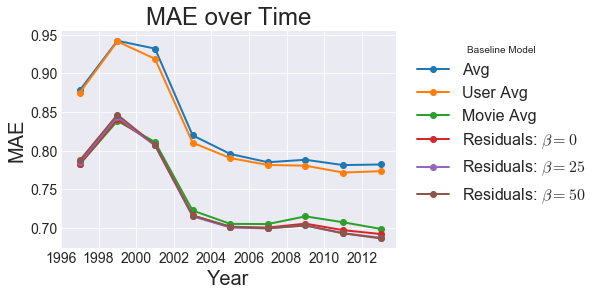

In [9]:
# <!-- collapse=True -->
plt.plot(years_1, errs_1, 'o-', label='Avg')
plt.plot(years_2, errs_2, 'o-', label='User Avg')
plt.plot(years_3, errs_3, 'o-', label='Movie Avg')
plt.plot(years_4, errs_4, 'o-', label=r'Residuals: $\beta=0$')
plt.plot(years_5, errs_5, 'o-', label=r'Residuals: $\beta=25$')
plt.plot(years_6, errs_6, 'o-', label=r'Residuals: $\beta=50$')
plt.gca().set_xticks(np.arange(1996, 2013, 2))
plt.xlabel('Year')
plt.ylabel('MAE')
plt.title('MAE over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Baseline Model')
plt.show()

The results here aren't too surprising. The Simple Average model performed the worst, with the User Average model perforing just slightly better. The biggest performance jump comes from using Movie Averages, simply because each movie typically has more ratings associated with it than each user. We get a little better by moving to the Damped Residuals model, then slightly better still by moving $\beta$ up to 25. Increasing beyond that appears to have negligible benefit.

Let's compare some distributions on the residuals of the predictions (prediction - actual) for 3 of these models: User Average, Movie Average, and Damped User+Movie with $\beta=25$:

In [10]:
# <!-- collapse=True -->
# Split data into training (before 2011) and testing (2011 through 2013)
train_inds, test_inds = ratings_df['year'] < 2011 , ratings_df['year'] >= 2011
X_train, X_test = ratings_df[train_inds].drop('rating', 1), ratings_df[test_inds].drop('rating', 1)
y_train, y_test = ratings_df.loc[train_inds, 'rating'], ratings_df.loc[test_inds, 'rating']

# Compute residuals for User Average model
model = AverageByIdModel()
model.fit(X_train['userId'], y_train)
user_residuals = model.predict(X_test['userId']) - y_test

# Compute residuals for Movie Average model
model.fit(X_train['movieId'], y_train)
movie_residuals = model.predict(X_test['movieId']) - y_test

# Compute residuals for Damped User+Movie model
model = DampedUserMovieBaselineModel(damping_factor=25)
model.fit(X_train, y_train)
damped_residuals = model.predict(X_test) - y_test

# Combine residuals in a dataframe to facilitate visualization
residuals_df = pd.DataFrame({
    'User': user_residuals, 'Movie': movie_residuals, 'Damped': damped_residuals
})
residuals_df = residuals_df.melt(var_name='Model', value_name='Residual')

Now that we have the residuals in a dataframe, let's plot those distributions and see how they compare:

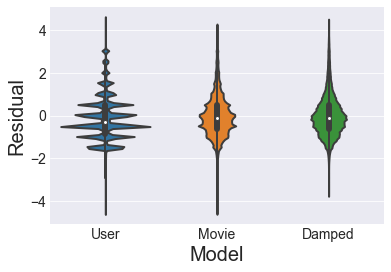

In [11]:
# <!-- collapse=True -->
sns.violinplot(x='Model', y='Residual', data=residuals_df, order=['User', 'Movie', 'Damped'])
plt.show()

The user model has a lot of regular peaks, likely because users have very few associated ratings compared to movies, so a lot of the user averages will be on half (\*.5) or quarter (\*.25) values. That gets smoothed out a lot for movies because there are typically more ratings, and then smoothed even further for the combined model because of the greater nuance enabled by combining user and movie averages, as well as a damping factor.

That's all for now! Next we'll do some actual collaborative filtering.